# Q1 Math

To demonstrate why the derivative of 𝛼 with respect to 𝜂 is zero under the Neyman Orthogonality condition, you must show that the objective function's sensitivity to 𝜂 at the true parameter values is minimal. Here’s a simplified approach:

1.	Objective Function: Consider a generic objective function 𝐿(𝛼,𝜂) that you minimize to estimate parameters. Suppose 𝐿 represents a loss function for the model 𝑦=𝛼𝐷+𝑏′𝑊+𝑒.

2.	Gradient with Respect to 𝜂η:
•	Compute the gradient ∇𝜂𝐿(𝛼,𝜂). For Neyman Orthogonality to hold, this gradient evaluated at the true parameter values (𝛼,𝜂0) must be zero, i.e., ∇𝜂𝐿(𝛼,𝜂0)=0.
•	This implies that at the optimum, small changes in 𝜂(nuisance parameters) do not affect the value of the loss function, indicating that the estimation of 𝛼α is stable against changes in 
𝜂.
3.	Second Derivative or Cross-Derivative:
•	Calculate ∂2𝐿/∂𝛼∂𝜂. For the derivative 𝑑𝛼/𝑑𝜂 to be zero, this cross-derivative should also ideally be zero at the optimum.
•	It means that the rate of change of the loss function with respect to 𝛼α does not change as 𝜂 changes slightly, confirming the insensitivity of 𝛼 to 𝜂.
4.	Implicit Function Theorem:
•	The theorem suggests that if 𝐹(𝛼,𝜂)=∇𝜂𝐿(𝛼,𝜂) and ∂𝐹∂𝜂 are well-defined and continuous, then around the true values, the function 𝛼(𝜂) behaves smoothly and does not react to minor perturbations in 𝜂.
5.	Practical Consideration: In practice, you often verify this condition through simulation or empirical testing, especially in complex econometric models where analytical solutions may be infeasible.


# Q2: Orthogonal Learning

In [108]:
import Pkg
Pkg.add("Distributions") 
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("Tables")
Pkg.add("GLM")
Pkg.add("CovarianceMatrices") 
Pkg.add("Gadfly")
Pkg.add("Lasso")

using Distributions
using DataFrames
using CSV
using Tables
using GLM
using CovarianceMatrices
using Gadfly
using Lasso
#include("../hdmjl.jl")
include("../Julia_Notebooks/hdmjl/hdmjl.jl")

   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolvi

In [ ]:
#### Code for each iteration

In [109]:
n = 10000
p = 100
beta = 1 ./ (1:p).^2    #px1 vector
gamma = 1 ./ (1:p).^2   #px1 vector
X = rand(Normal(0,1), n, p) #nxp matrix
D = X * gamma + (rand(Normal(0,1), n, 1) / 4)  #nx1 vector
Y = 10 * D + X * beta + rand(Normal(0,1), n, 1) #nx1 vector
X1 = hcat(D,X)

#---As DataFrames---#
colnames_X = []
colnames_D = [:D]
colnames_Y = [:Y]
colnames_X1 = [:D]
for i in 1:100
    push!(colnames_X, Symbol("x$i"))
    push!(colnames_X1, Symbol("x$i"))
end
X_df = DataFrame(X, colnames_X)
D_df = DataFrame(D, colnames_D)
Y_df = DataFrame(Y, colnames_Y)
X1_df = DataFrame(X1, colnames_X1)


#--------------#
#---NAIVE------#
#--------------#
model1=rlasso_arg( X1_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

coef1 = rlasso(model1)["coefficients"][3:102,2]                    #elements 1 and 2 are the intercept and D's coefficient 
SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )   #idexes where b_hat=0

#If all coefficients from X are 0
if (all(coef1[SX_IDs, :] .==0)) 
    Y1 = hcat(Y_df, D_df)
    print(coef(lm(@formula(Y ~ D), Y1))[2]) #enlace con Naive
end

#If some coefficients from X are non-zero
if (any(coef1[SX_IDs, :] .!=0))

    Y2 = hcat(Y_df, D_df, X_df[:, SX_IDs])

    #Generating formula
    varnames = names(Y2)[3:end]                        #x_i from X_df[:, SX_IDs]
    formula_str = "D + " * join(varnames, " + ")
    expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))

    print(coef(lm(expression, Y2))[2]) #enlace con Naive

end

#-------------------#
#---ORTHOGONAL------#
#-------------------#
model2 =rlasso_arg( X_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
model3 =rlasso_arg( X_df, D_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

resY = rlasso(model2)["residuals"]                  #Y cleared of effects from X
resD = rlasso(model3)["residuals"]                  #D cleared of effects from X
Y3=DataFrame(hcat(resY,resD),["resY","resD"])

coef(lm(@formula(resY ~ resD), Y3))[2] #enlace orthogonal

10.943797301042654

10.038293176391269

In [ ]:
#### B=100 iterations

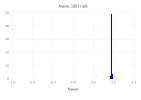

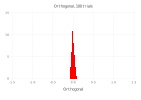

In [110]:
B = 100
Naive = zeros(B)
Orthogonal = zeros(B)

#Multithreading 
Threads.@threads for i in 1:B
    
    #---(1) DGP simulation---#
    #------------------------#
    n = 10000
    p = 100
    beta = 1 ./ (1:p).^2    #px1 vector
    gamma = 1 ./ (1:p).^2   #px1 vector
    X = rand(Normal(0,1), n, p) #nxp matrix
    D = X * gamma + (rand(Normal(0,1), n, 1) / 4)  #nx1 vector
    Y = 10 * D + X * beta + rand(Normal(0,1), n, 1) #nx1 vector
    X1 = hcat(D,X)
    colnames_X = []
    colnames_D = [:D]
    colnames_Y = [:Y]
    colnames_X1 = [:D]
    for i in 1:100
        push!(colnames_X, Symbol("x$i"))
        push!(colnames_X1, Symbol("x$i"))
    end
    X_df = DataFrame(X, colnames_X)
    D_df = DataFrame(D, colnames_D)
    Y_df = DataFrame(Y, colnames_Y)
    X1_df = DataFrame(X1, colnames_X1)

    #---(2) Naive Learning---#
    #------------------------#
    #model1=rlasso_arg( X1_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #rlasso(model1)
    #coef1 = rlasso(model1)["coefficients"][3:102,2]                    
    #SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )   #idexes where b_hat=0
    df = hcat(Y_df, X1_df)
    varnames = names(df)[3:end]  
    formula_str = "D + " * join(varnames, " + ")
    expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))

    model1=fit(LassoModel, expression, df)
    coef1 = coef(model1)
    SX_IDs = findall(coef1[3:102] .==0)

    #If all coefficients from X are 0 
    if (all(coef1[SX_IDs, :] .==0)) 
        Y1 = hcat(Y_df, D_df)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end
    #If some coefficients from X are non-zero
    if (any(coef1[SX_IDs, :] .==0))
        Y2 = hcat(Y_df, D_df, X_df[:, SX_IDs])
        #Generating formula
        varnames = names(Y2)[3:end]                        #x_i from X_df[:, SX_IDs]
        formula_str = "D + " * join(varnames, " + ")
        expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))
        Naive[i] = (coef(lm(expression, Y2))[2]) - 10
    end


    #---(3) Orthogonal Learning---#
    #-----------------------------#
    #model2 =rlasso_arg( X_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #model3 =rlasso_arg( X_df, D_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    df2 = hcat(Y_df, X_df)
    df3 = hcat(D_df, X_df)

    varnames2 = names(df2)[2:end]  
    formula_str2 =  join(varnames2, " + ")
    expression2 = @eval(@formula(Y ~ $(Meta.parse(formula_str2))))
    varnames3 = names(df2)[2:end]  
    formula_str3 = join(varnames3, " + ")
    expression3 = @eval(@formula(D ~ $(Meta.parse(formula_str3))))

    model2=fit(LassoModel, expression2, df2)
    model3=fit(LassoModel, expression3, df3)

    resY = residuals(model2)
    resD = residuals(model3)
    df4 = DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i] = coef(lm(@formula(resY ~ resD), df4))[2] - 10

    #resY = rlasso(model2)["residuals"]                  #Y cleared of effects from X
    #resD = rlasso(model3)["residuals"]                  #D cleared of effects from X
    #Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    #Orthogonal[i] = coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end

results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 100 trials")
))
display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 100 trials")
))


In [ ]:
#### B=1000 iterations

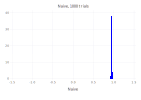

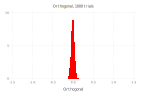

In [111]:
B = 1000
Naive = zeros(B)
Orthogonal = zeros(B)

#Multithreading 
Threads.@threads for i in 1:B
    
    #---(1) DGP simulation---#
    #------------------------#
    n = 10000
    p = 100
    beta = 1 ./ (1:p).^2    #px1 vector
    gamma = 1 ./ (1:p).^2   #px1 vector
    X = rand(Normal(0,1), n, p) #nxp matrix
    D = X * gamma + (rand(Normal(0,1), n, 1) / 4)  #nx1 vector
    Y = 10 * D + X * beta + rand(Normal(0,1), n, 1) #nx1 vector
    X1 = hcat(D,X)
    colnames_X = []
    colnames_D = [:D]
    colnames_Y = [:Y]
    colnames_X1 = [:D]
    for i in 1:100
        push!(colnames_X, Symbol("x$i"))
        push!(colnames_X1, Symbol("x$i"))
    end
    X_df = DataFrame(X, colnames_X)
    D_df = DataFrame(D, colnames_D)
    Y_df = DataFrame(Y, colnames_Y)
    X1_df = DataFrame(X1, colnames_X1)

    #---(2) Naive Learning---#
    #------------------------#
    #model1=rlasso_arg( X1_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #rlasso(model1)
    #coef1 = rlasso(model1)["coefficients"][3:102,2]                    
    #SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )   #idexes where b_hat=0
    df = hcat(Y_df, X1_df)
    varnames = names(df)[3:end]  
    formula_str = "D + " * join(varnames, " + ")
    expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))

    model1=fit(LassoModel, expression, df)
    coef1 = coef(model1)
    SX_IDs = findall(coef1[3:102] .==0)

    #If all coefficients from X are 0 
    if (all(coef1[SX_IDs, :] .==0)) 
        Y1 = hcat(Y_df, D_df)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end
    #If some coefficients from X are non-zero
    if (any(coef1[SX_IDs, :] .==0))
        Y2 = hcat(Y_df, D_df, X_df[:, SX_IDs])
        #Generating formula
        varnames = names(Y2)[3:end]                        #x_i from X_df[:, SX_IDs]
        formula_str = "D + " * join(varnames, " + ")
        expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))
        Naive[i] = (coef(lm(expression, Y2))[2]) - 10
    end


    #---(3) Orthogonal Learning---#
    #-----------------------------#
    #model2 =rlasso_arg( X_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #model3 =rlasso_arg( X_df, D_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    df2 = hcat(Y_df, X_df)
    df3 = hcat(D_df, X_df)

    varnames2 = names(df2)[2:end]  
    formula_str2 =  join(varnames2, " + ")
    expression2 = @eval(@formula(Y ~ $(Meta.parse(formula_str2))))
    varnames3 = names(df2)[2:end]  
    formula_str3 = join(varnames3, " + ")
    expression3 = @eval(@formula(D ~ $(Meta.parse(formula_str3))))

    model2=fit(LassoModel, expression2, df2)
    model3=fit(LassoModel, expression3, df3)

    resY = residuals(model2)
    resD = residuals(model3)
    df4 = DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i] = coef(lm(@formula(resY ~ resD), df4))[2] - 10

    #resY = rlasso(model2)["residuals"]                  #Y cleared of effects from X
    #resD = rlasso(model3)["residuals"]                  #D cleared of effects from X
    #Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    #Orthogonal[i] = coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end

results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 1000 trials")
))
display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 1000 trials")
))

In [ ]:
#### B=10000 iterations

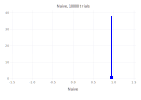

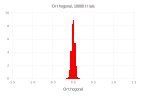

In [112]:
B = 10000
Naive = zeros(B)
Orthogonal = zeros(B)

#Multithreading 
Threads.@threads for i in 1:B
    
    #---(1) DGP simulation---#
    #------------------------#
    n = 10000
    p = 100
    beta = 1 ./ (1:p).^2    #px1 vector
    gamma = 1 ./ (1:p).^2   #px1 vector
    X = rand(Normal(0,1), n, p) #nxp matrix
    D = X * gamma + (rand(Normal(0,1), n, 1) / 4)  #nx1 vector
    Y = 10 * D + X * beta + rand(Normal(0,1), n, 1) #nx1 vector
    X1 = hcat(D,X)
    colnames_X = []
    colnames_D = [:D]
    colnames_Y = [:Y]
    colnames_X1 = [:D]
    for i in 1:100
        push!(colnames_X, Symbol("x$i"))
        push!(colnames_X1, Symbol("x$i"))
    end
    X_df = DataFrame(X, colnames_X)
    D_df = DataFrame(D, colnames_D)
    Y_df = DataFrame(Y, colnames_Y)
    X1_df = DataFrame(X1, colnames_X1)

    #---(2) Naive Learning---#
    #------------------------#
    #model1=rlasso_arg( X1_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #rlasso(model1)
    #coef1 = rlasso(model1)["coefficients"][3:102,2]                    
    #SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )   #idexes where b_hat=0
    df = hcat(Y_df, X1_df)
    varnames = names(df)[3:end]  
    formula_str = "D + " * join(varnames, " + ")
    expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))

    model1=fit(LassoModel, expression, df)
    coef1 = coef(model1)
    SX_IDs = findall(coef1[3:102] .==0)

    #If all coefficients from X are 0 
    if (all(coef1[SX_IDs, :] .==0)) 
        Y1 = hcat(Y_df, D_df)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end
    #If some coefficients from X are non-zero
    if (any(coef1[SX_IDs, :] .==0))
        Y2 = hcat(Y_df, D_df, X_df[:, SX_IDs])
        #Generating formula
        varnames = names(Y2)[3:end]                        #x_i from X_df[:, SX_IDs]
        formula_str = "D + " * join(varnames, " + ")
        expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))
        Naive[i] = (coef(lm(expression, Y2))[2]) - 10
    end


    #---(3) Orthogonal Learning---#
    #-----------------------------#
    #model2 =rlasso_arg( X_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #model3 =rlasso_arg( X_df, D_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    df2 = hcat(Y_df, X_df)
    df3 = hcat(D_df, X_df)

    varnames2 = names(df2)[2:end]  
    formula_str2 =  join(varnames2, " + ")
    expression2 = @eval(@formula(Y ~ $(Meta.parse(formula_str2))))
    varnames3 = names(df2)[2:end]  
    formula_str3 = join(varnames3, " + ")
    expression3 = @eval(@formula(D ~ $(Meta.parse(formula_str3))))

    model2=fit(LassoModel, expression2, df2)
    model3=fit(LassoModel, expression3, df3)

    resY = residuals(model2)
    resD = residuals(model3)
    df4 = DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i] = coef(lm(@formula(resY ~ resD), df4))[2] - 10

    #resY = rlasso(model2)["residuals"]                  #Y cleared of effects from X
    #resD = rlasso(model3)["residuals"]                  #D cleared of effects from X
    #Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    #Orthogonal[i] = coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end

results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 10000 trials")
))
display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 10000 trials")
))

In [ ]:
#### Comparing times

In [ ]:
B = 100
Naive = zeros(B)
Orthogonal = zeros(B)

#Multithreading 
t0_parallel = time()
Threads.@threads for i in 1:B
    
    #---(1) DGP simulation---#
    #------------------------#
    
    n = 10000
    p = 100
    beta = 1 ./ (1:p).^2    #px1 vector
    gamma = 1 ./ (1:p).^2   #px1 vector
    X = rand(Normal(0,1), n, p) #nxp matrix
    D = X * gamma + (rand(Normal(0,1), n, 1) / 4)  #nx1 vector
    Y = 10 * D + X * beta + rand(Normal(0,1), n, 1) #nx1 vector
    X1 = hcat(D,X)
    colnames_X = []
    colnames_D = [:D]
    colnames_Y = [:Y]
    colnames_X1 = [:D]
    for i in 1:100
        push!(colnames_X, Symbol("x$i"))
        push!(colnames_X1, Symbol("x$i"))
    end
    X_df = DataFrame(X, colnames_X)
    D_df = DataFrame(D, colnames_D)
    Y_df = DataFrame(Y, colnames_Y)
    X1_df = DataFrame(X1, colnames_X1)

    #---(2) Naive Learning---#
    #------------------------#
    #model1=rlasso_arg( X1_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #rlasso(model1)
    #coef1 = rlasso(model1)["coefficients"][3:102,2]                    
    #SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )   #idexes where b_hat=0
    df = hcat(Y_df, X1_df)
    varnames = names(df)[3:end]  
    formula_str = "D + " * join(varnames, " + ")
    expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))

    model1=fit(LassoModel, expression, df)
    coef1 = coef(model1)
    SX_IDs = findall(coef1[3:102] .==0)

    #If all coefficients from X are 0 
    if (all(coef1[SX_IDs, :] .==0)) 
        Y1 = hcat(Y_df, D_df)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end
    #If some coefficients from X are non-zero
    if (any(coef1[SX_IDs, :] .==0))
        Y2 = hcat(Y_df, D_df, X_df[:, SX_IDs])
        #Generating formula
        varnames = names(Y2)[3:end]                        #x_i from X_df[:, SX_IDs]
        formula_str = "D + " * join(varnames, " + ")
        expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))
        Naive[i] = (coef(lm(expression, Y2))[2]) - 10
    end


    #---(3) Orthogonal Learning---#
    #-----------------------------#
    #model2 =rlasso_arg( X_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #model3 =rlasso_arg( X_df, D_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    df2 = hcat(Y_df, X_df)
    df3 = hcat(D_df, X_df)

    varnames2 = names(df2)[2:end]  
    formula_str2 =  join(varnames2, " + ")
    expression2 = @eval(@formula(Y ~ $(Meta.parse(formula_str2))))
    varnames3 = names(df2)[2:end]  
    formula_str3 = join(varnames3, " + ")
    expression3 = @eval(@formula(D ~ $(Meta.parse(formula_str3))))

    model2=fit(LassoModel, expression2, df2)
    model3=fit(LassoModel, expression3, df3)

    resY = residuals(model2)
    resD = residuals(model3)
    df4 = DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i] = coef(lm(@formula(resY ~ resD), df4))[2] - 10

    #resY = rlasso(model2)["residuals"]                  #Y cleared of effects from X
    #resD = rlasso(model3)["residuals"]                  #D cleared of effects from X
    #Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    #Orthogonal[i] = coef(lm(@formula(resY ~ resD), Y3))[2] - 10
    
    

end
t1_parallel = time()
time_elapsed_parallel = t1_parallel - t0_parallel

println("Completing this loop without parallel takes ", time_elapsed, " seconds")
println("Completing this loop with parallel takes ", time_elapsed_parallel, " seconds")

This could only be run in VScode. The result was the following:
Julia Version 1.10.2
Commit bd47eca2c8 (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 16 × AMD Ryzen 7 5800HS with Radeon Graphics
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, znver3)
Threads: 4 default, 0 interactive, 2 GC (on 16 virtual cores)
Environment:
  JULIA_EDITOR = code
  JULIA_NUM_THREADS = 4
Completing this loop without parallel takes 95.27900004386902 seconds
Completing this loop with parallel takes 38.16000008583069 seconds

Using parallel (multithreading) decreases the running time of all three loops. This is because multiple itereations can be excecuted at the same time, each by a single threadid. This way, we don't need to wait for one iteration to finish to start the next one. 

# Q3: Double Lasso - Using School data

In [1]:
import Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")

using CSV
using DataFrames

   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`


In [20]:
#df = CSV.read("C:/Users/ALBERTO TRELLES/Documents/Alberto/Ciclos/Ciclo 9/ML & causal inference/workgroup3/bruhn2016.csv", DataFrame)
df = CSV.read("C:/Users/ALBERTO TRELLES/Documents/Alberto/Ciclos/Ciclo 9/ML & causal inference/workgroup3/bruhn2016_naomit.csv", DataFrame)

#---Data Management---#
print(names(df))
colnames_df = [:Y, :D]
for i in 1:(size(df)[2]-2)
    push!(colnames_df, Symbol("x$i"))
end
df = DataFrame(df, colnames_df)

#Describing de dataset
for i in 1:(size(df, 2)-2)
    var = Symbol("x$i")
    print(describe(select(df, var)))
end
#x11 and x14 are index variables (treat them as floats)
df[!, :x11] = ifelse.(df[!, :x11] .== "NA", missing, df[!, :x11]); df[!, :x14] = ifelse.(df[!, :x14] .== "NA", missing, df[!, :x14])
df = dropmissing!(df, :x11); df = dropmissing!(df, :x14)
df.x11 = convert(Vector{Float64}, df.x11); df.x14 = convert(Vector{Float64}, df.x11)

["outcome.test.score", "treatment", "school", "is.female", "mother.attended.secondary.school", "father.attened.secondary.school", "failed.at.least.one.school.year", "family.receives.cash.transfer", "has.computer.with.internet.at.home", "is.unemployed", "has.some.form.of.income", "saves.money.for.future.purchases", "intention.to.save.index", "makes.list.of.expenses.every.month", "negotiates.prices.or.payment.methods", "financial.autonomy.index"]1×7 DataFrame
 Row │ variable  mean       min       median     max       nmissing  eltype   
     │ Symbol    Float64    Int64     Float64    Int64     Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────
   1 │ x1        3.24115e7  17000386  3.30908e7  53068181         0  Int641×7 DataFrame
 Row │ variable  mean      min    median   max    nmissing  eltype   
     │ Symbol    Float64   Int64  Float64  Int64  Int64     DataType 
─────┼───────────────────────────────────────────────────────────────
   

12222-element Vector{Float64}:
 48.0
 42.0
 50.0
 93.0
 52.0
 50.0
 59.0
 44.0
 60.0
 47.0
 13.0
 67.0
 42.0
  ⋮
 38.0
 41.0
 88.0
 38.0
 25.0
 61.0
 60.0
 56.0
 77.0
 34.0
 15.0
 79.0

In [ ]:
#### (1) OLS

In [22]:
using GLM
varnames = names(df)[4:end]  
formula_str = "D + " * join(varnames, " + ")
expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))

model1 = lm(expression, df)   #GLM controls for missing values 
beta_D1 = coef(model1)[2]
ci_D1 = confint(model1)[2, :]

2-element Vector{Float64}:
 3.8118202027782173
 4.776387325662239

In [ ]:
#### (2) Lasso CV

In [27]:
import Pkg; Pkg.add("MLBase")
using MLBase
using Lasso

   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`


In [28]:
model2 = fit(LassoModel, expression, df; select=MinCVmse(Kfold(3, 2)))

StatsModels.TableRegressionModel{LassoModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, MinCVmse}, Matrix{Float64}}

Y ~ D + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14

Coefficients:
LassoModel using MinCVmse(Kfold([2, 3, 1], 2, 1.5)) segment of the regularization path.

Coefficients:
────────────────
        Estimate
────────────────
x1   49.4221
x2    4.23178
x3    2.56333
x4    0.744788
x5    0.684304
x6   -5.89034
x7   -1.49643
x8   -0.0967333
x9   -2.06948
x10   2.1092
x11  -0.308438
x12   0.157174
x13  -1.96087
x14   0.0
x15   0.00178997
────────────────


In [29]:
beta_D2 = coef(model2)[2]
ci_D2 = confint(model2)[2, :]

2-element Vector{Float64}:
 3.7494805536636338
 4.714073676078587

#### (3) Lasso - Theoretical Lambda

In [42]:
include("../Julia_Notebooks/hdmjl/hdmjl.jl")
using Lasso

In [46]:
model3=fit(LassoModel, expression, df)
beta_D3 = coef(model3)[2]
ci_D3 = confint(model3)[2, :]


2-element Vector{Float64}:
 3.7494805536636338
 4.714073676078587

In [38]:
#### (4) Lasso - Partialling out

LoadError: MethodError: no method matching rlasso(::Matrix{Float64}, ::Vector{Float64})

In [63]:
using HDMjl
Y_df = Matrix(select(df, :Y))
X_df = Matrix(select(df, Not(:Y, :D)))
d_df = Matrix(select(df, :D))

model4 = rlassoEffect(X_df, Y_df, d_df, method = "double selection")


HDMjl.rlassoEffect1(0.24636230065127293, 12222, 4.293000060842482, Dict{String, Any}("alpha" => 4.293000060842482, "t" => 17.425555977897954, "se" => 0.24636230065127293, "no_select" => 0, "coefficients_reg" => [49.21535466795026, 4.293000060842482, 2.6327326964899402, 0.7861330362444195, 0.7286632085602914, -5.943155176347496, -1.5676992296565722, -2.1908129730447636, 2.2043450012669803, 0.15968538987556047, -2.131676446387151, 0.0], "sample_size" => 12222, "coefficient" => 4.293000060842482, "selection_index" => Bool[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1], "residuals" => Dict("v" => [0.5018739572761199, -0.49562724067001585, 0.48179880706201894, -0.5295913216430032, -0.5149869211880348, -0.5275598809149069, 0.5014577545804871, 0.48824120188587006, -0.5112021433151825, 0.4696404565413689  …  0.46438248622877853, 0.47202262798588257, 0.4366640885484515, -0.5271771807406306, 0.46575412736078925, 0.469121414134431, -0.5072956967745117, 0.4785346046596022, -0.4965665956432395, -0.50369

In [81]:
coef_D4 = r_summary(model4)[1,1]
se_D4 = r_summary(model4)[1,2]
ci_D4 = [coef_D4 - 1.96*se_D4, coef_D4 + 1.96*se_D4]    #r_coefint(model4) wasn't recognized

Estimates and significance testing of the effect of target variables
  Row   Estimate.   Std. Error    t value   Pr(>|t|) 

    1       4.293      0.24636   17.42572    0.0 ***
---
Signif. codes:
0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Estimates and significance testing of the effect of target variables
  Row   Estimate.   Std. Error    t value   Pr(>|t|) 

    1       4.293      0.24636   17.42572    0.0 ***
---
Signif. codes:
0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


2-element Vector{Float64}:
 3.8101344
 4.7758656

#### Plots

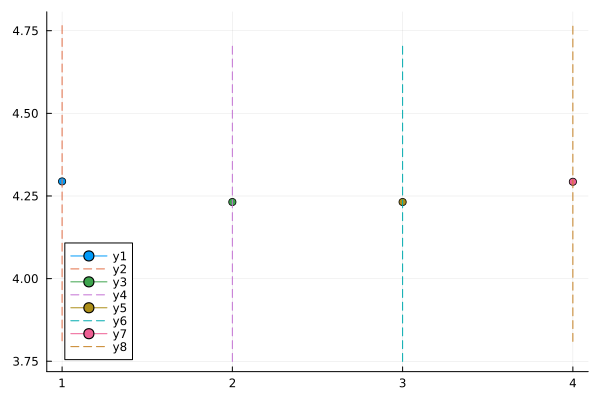

In [106]:
using Plots

plot([1], [beta_D1], marker=:circle)
plot!([1, 1], [ci_D1[1], ci_D1[2]], marker=:none, line=:dash)

plot!([2], [beta_D2], marker=:circle)
plot!([2, 2], [ci_D2[1], ci_D2[2]], marker=:none, line=:dash)

plot!([3], [beta_D3], marker=:circle)
plot!([3, 3], [ci_D3[1], ci_D3[2]], marker=:none, line=:dash)

plot!([4], [coef_D4], marker=:circle)
plot!([4, 4], [ci_D4[1], ci_D4[2]], marker=:none, line=:dash)



We found the average treatment effect was estimated at around 4.25. While different methods changed the condifence intervals, the gain in efficiency isn't very big. 